This notebook performs the following validations on the forecasting models:
1. Calibration
2. Comparison Harvey vs logistic
3. Comparison independant vs joint model

# Imports and load dataset

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import energy_distance
from typing import Literal
import itertools

/Users/antoinemaier/Documents/Semaphore/benchmark-forecasting/.venv/lib/python3.14/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


# Tools

## Modelling

In [7]:
def load_dataset(
    path: str = "benchmark_data_processed/all_normalized_updated_benchmarks.csv",
) -> pd.DataFrame:
    """Load the benchmark dataset from a formatted CSV file and returns it as a pandas DataFrame with appropriate data types."""
    dataset = (
        pd.read_csv(path)
        .astype(
            {
                "benchmark": "string",
                "release_date": "datetime64[ns]",
                "score": "float64",
                "lower_bound": "float64",
            }
        )
        .dropna(subset=["benchmark", "release_date", "score", "lower_bound"])
    )
    return dataset


def format_dataset_for_modeling(
    dataset: pd.DataFrame,
    top_n: int = 3,
) -> pd.DataFrame:
    """Prepare the dataset for modeling by filtering to the top_n frontier scores and adding necessary columns.

    Args:
        dataset: A dataset containing benchmark data.
        top_n: Number of top scores to consider when fitting the model.
    Returns:
        A formatted dataset ready for modeling.
    """
    dataset = _get_frontier(dataset, top_n=top_n)
    dataset = dataset.assign(
        days=lambda df: (
            df["release_date"]
            - df.groupby("benchmark")["release_date"].transform("min")
        ).dt.days
    ).assign(
        # Midpoint of the time range in days is simple the max divided by two since min is zero
        days_mid=lambda df: (df.groupby("benchmark")["days"].transform("max") / 2.0)
    )
    return dataset


def fit_model(
    dataset: pd.DataFrame,
    sigmoid_kind: Literal["logistic", "harvey"] = "logistic",
    joint: bool = True,
    top_n: int = 3,
    n_samples: int = 2000,
    n_tune: int = 1000,
    progressbar: bool = True,
) -> tuple[az.InferenceData, pm.Model]:
    """Fit a Bayesian model to the dataset using the specified sigmoid function.

    This allows benchmarks to inform each other through common priors on:
    - L_mu, L_sigma: (upper) asymptote distribution parameters
    - k_mu, k_sigma: growth rate distribution parameters
    - xi_base_mu, xi_base_sigma: noise level distribution parameters
    - s_mu, s_sigma: skewness distribution parameters

    Args:
        dataset: A dataset containing benchmark data. It must be formatted by `format_dataset_for_modeling` first.
        sigmoid_kind: Type of sigmoid function to model the latent mean performance growth ('logistic' or 'harvey').
        joint: Whether to fit a joint model with shared hyperparameters across benchmarks.
        top_n: Number of top scores to consider when fitting the model. If top_n=1, only the frontier scores are used.
        n_samples: Number of MCMC samples to draw from the posterior distribution.
        n_tune: Number of tuning steps for the MCMC sampler.
        progressbar: Whether to display a progress bar during sampling.

    Returns:
        A tuple containing an arviz InferenceData object with the posterior samples and the pymc Model object.
    """
    benchmark_idx, benchmark_names = pd.factorize(dataset["benchmark"], sort=True)
    dataset["benchmark_idx"] = benchmark_idx
    coords = {
        "benchmark": benchmark_names,
        "obs": dataset.index,
    }

    with pm.Model(coords=coords) as model:
        # Upper asymptote
        L_min = 0.75
        L_max = 1.0
        L_range = L_max - L_min
        L_raw_mu = pm.Beta(
            "L_raw_mu",
            mu=(0.96 - L_min) / L_range,
            sigma=0.02 / L_range,
            dims=None if joint else "benchmark",
        )
        L_raw_sigma = pm.HalfNormal(
            "L_raw_sigma", sigma=0.02 / L_range, dims=None if joint else "benchmark"
        )
        L_raw = pm.Beta("L_raw", mu=L_raw_mu, sigma=L_raw_sigma, dims="benchmark")
        L = pm.Deterministic("L", L_min + L_range * L_raw, dims="benchmark")

        # Lower bound
        l = pm.Data(
            "l",
            dataset["lower_bound"].groupby(dataset["benchmark_idx"]).first().values,
            dims="benchmark",
        )

        # Inflection point
        days_mid = dataset["days_mid"].groupby(dataset["benchmark_idx"]).first().values
        tau = pm.Gumbel("tau", mu=days_mid, beta=365 * 2, dims="benchmark")

        # Times of observations
        t = pm.Data("t_obs", dataset["days"].values, dims="obs")
        idx_obs = pm.Data("idx_obs", dataset["benchmark_idx"].values, dims="obs")

        # Growth rate
        k_mu = pm.Gamma(
            "k_mu", mu=0.005, sigma=0.002, dims=None if joint else "benchmark"
        )
        k_sigma = pm.HalfNormal(
            "k_sigma", sigma=0.005, dims=None if joint else "benchmark"
        )
        k = pm.Gamma("k", mu=k_mu, sigma=k_sigma, dims="benchmark")

        # Mean latent performance
        logits = k[idx_obs] * (t - tau[idx_obs])
        if sigmoid_kind == "logistic":
            sigmoid = pm.math.sigmoid(logits)
        elif sigmoid_kind == "harvey":
            alpha_raw_mu = pm.Gamma(
                "alpha_raw_mu", mu=1.5, sigma=0.5, dims=None if joint else "benchmark"
            )
            alpha_raw_sigma = pm.HalfNormal(
                "alpha_raw_sigma", sigma=0.5, dims=None if joint else "benchmark"
            )
            alpha_raw = pm.Gamma(
                "alpha_raw", mu=alpha_raw_mu, sigma=alpha_raw_sigma, dims="benchmark"
            )
            alpha = pm.Deterministic("alpha", alpha_raw + 1.0, dims="benchmark")
            base = pm.math.maximum(
                1 - (1 - alpha[idx_obs]) * pm.math.exp(-logits), 1e-10
            )
            sigmoid = pm.math.exp(1 / (1 - alpha[idx_obs]) * pm.math.log(base))
        else:
            raise ValueError(f"Unsupported sigmoid type: {sigmoid_kind}")
        mu = pm.Deterministic("mu", l[idx_obs] + (L[idx_obs] - l[idx_obs]) * sigmoid, dims="obs")

        # Noise
        xi_base_mu = pm.Gamma(
            "xi_base_mu",
            mu=0.05 + top_n / 50,
            sigma=0.02,
            dims=None if joint else "benchmark",
        )
        xi_base_sigma = pm.HalfNormal(
            "xi_base_sigma", sigma=0.05, dims=None if joint else "benchmark"
        )
        xi_base = pm.Gamma(
            "xi_base", mu=xi_base_mu, sigma=xi_base_sigma, dims="benchmark"
        )
        variance_shape = pm.math.sqrt((mu - l[idx_obs]) * (L[idx_obs] - mu))
        max_variance = (L[idx_obs] - l[idx_obs]) / 2.0
        noise_factor = variance_shape / pm.math.maximum(max_variance, 1e-10)
        xi_0 = 0.01
        xi = xi_0 + xi_base[idx_obs] * noise_factor

        # Skewness
        s_mu = pm.Normal(
            "s_mu", mu=-2 - top_n / 2, sigma=0.5, dims=None if joint else "benchmark"
        )
        s_sigma = pm.HalfNormal("s_sigma", sigma=1, dims=None if joint else "benchmark")
        s = pm.TruncatedNormal("s", mu=s_mu, sigma=s_sigma, upper=0, dims="benchmark")

        # Observations
        y = pm.SkewNormal(
            "y",
            mu=mu,
            sigma=xi,
            alpha=s[idx_obs],
            observed=dataset["score"].values,
            dims="obs",
        )

        # Sample from the posterior
        idata = pm.sample(
            n_samples,
            tune=n_tune,
            return_inferencedata=True,
            random_seed=42,
            target_accept=0.9,
            init="adapt_diag",
            progressbar=progressbar,
        )

    return idata, model


def _get_frontier(df: pd.DataFrame, top_n: int = 1) -> pd.DataFrame:
    """Filter the dataset to include only the top_n frontier scores for each benchmark.

    Args:
        df: A dataset with columns "benchmark", "release_date", and "score".
        top_n: Number of top scores to consider when filtering the dataset.
    Returns:
        A filtered dataset containing only the top_n frontier scores for each benchmark.
    """
    return (
        df.sort_values(["benchmark", "release_date"])
        .assign(
            expanding_rank=lambda df: df.groupby("benchmark")["score"]
            .expanding()
            .rank(ascending=False, method="max")
            .reset_index(level=0, drop=True)
        )
        .loc[lambda df: df["expanding_rank"] <= top_n]
        .drop(columns=["expanding_rank"])
        .reset_index(drop=True)
    )


## Validation

In [3]:
def temporal_holdout(
    dataset: pd.DataFrame,
    cutoff_date: pd.Timestamp,
    sigmoid_kind: Literal["logistic", "harvey"] = "harvey",
    joint: bool = True,
    top_n: int = 3,
    progressbar: bool = True,
) -> az.InferenceData:
    """Validate the model by training on data before the cutoff date and testing on data after cutoff date.

    Args:
        dataset: A dataset containing benchmark data.
        cutoff_date: A timestamp to split the dataset into training and testing sets.
        sigmoid_kind: Type of sigmoid function to model the latent mean performance growth ('logistic' or 'harvey').
        joint: Whether to fit a joint model with shared hyperparameters across benchmarks.
        top_n: Top-n frontier scores to consider in the modeling.
        progressbar: Whether to display a progress bar during sampling.
    Returns:
        An arviz InferenceData object containing the posterior samples from the cross-validation in the `predictions` group and true observed values in the `predictions` group.
    """
    dataset = format_dataset_for_modeling(dataset, top_n=top_n)
    # Split dataset into training and testing sets
    train_dataset = (
        dataset.loc[dataset["release_date"] < cutoff_date]
        # Fitler out benchmarks with insufficient data at the cutoff date
        .loc[
            lambda df: df.groupby("benchmark").transform("size")
            >= dataset["benchmark"].value_counts().min()
        ]
    )
    test_dataset = dataset[dataset["release_date"] >= cutoff_date][
        # Filter out benchmarks not present in training set
        dataset["benchmark"].isin(train_dataset["benchmark"].unique())
    ]
    # Train the model on the training dataset
    idata, model = fit_model(
        train_dataset,
        sigmoid_kind=sigmoid_kind,
        joint=joint,
        top_n=top_n,
        progressbar=progressbar,
    )
    # Benchmark indices corresponding to those used in the trained_dataset
    # Needed for pymc something, unclear what exactly
    test_dataset["benchmark_idx"] = pd.Categorical(
        test_dataset["benchmark"],
        categories=model.coords["benchmark"],
        ordered=True,
    ).codes
    with model:
        pm.set_data(
            {
                "t_obs": test_dataset["days"].values,
                "idx_obs": test_dataset["benchmark_idx"].values,
            },
            coords={"obs": test_dataset.index},
        )
        idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=42,
            progressbar=progressbar,
        )
    # Add true observed values to the predictions group for evaluation
    idata.predictions["y_true"] = (("obs"), test_dataset["score"].values)
    return idata


def plot_calibration_curve(idata: az.InferenceData) -> None:
    """Plot the calibration curve for the model's predictions.

    Args:
        idata: An arviz InferenceData object containing the posterior predictive samples `y` and true observed values `y_true` in the `predictions` group.
    """
    y_pred = idata.predictions.stack(sample=("chain", "draw"))["y"].values
    y_true = idata.predictions["y_true"].values

    confidence_levels = np.linspace(0.01, 0.99, 20)
    observed_coverage = []
    for p in confidence_levels:
        lower_quantile = (1 - p) / 2
        upper_quantile = 1 - lower_quantile
        lower_bound = np.quantile(y_pred, lower_quantile, axis=1)
        upper_bound = np.quantile(y_pred, upper_quantile, axis=1)
        is_inside = (y_true >= lower_bound) & (y_true <= upper_bound)
        observed_coverage.append(np.mean(is_inside))

    plt.figure(figsize=(8, 8))
    plt.plot(confidence_levels, observed_coverage, "o-", label="Model Calibration")
    plt.plot([0, 1], [0, 1], "k--", label="Ideal (Perfectly Calibrated)")
    plt.xlabel("Expected Confidence Level (Interval Width)")
    plt.ylabel("Observed Coverage (Fraction of Test Data inside Interval)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()


def crps(idata: az.InferenceData) -> float:
    """Compute the Continuous Ranked Probability Score (CRPS) for the model's predictions.

    Args:
        idata: An arviz InferenceData object containing the posterior predictive samples `y` and true observed values `y_true` in the `predictions` group.
    Returns:
        The mean CRPS value across all test data points.
    """
    y_pred = idata.predictions.stack(sample=("chain", "draw"))["y"].values
    y_true = idata.predictions["y_true"].values

    crps = []
    for i, (pred, true) in enumerate(zip(y_pred, y_true)):
        # `true` is just a number, need to make it an array-like for `energy_distance`
        # Squared energy distance divided by 2 equals CRPS
        crps.append(energy_distance(pred, (true,)) ** 2 / 2)
    return np.mean(crps)


def accuracy(idata: az.InferenceData, metric: Literal["RMSE", "MAE"] = "RMSE") -> float:
    """Compute the accuracy for the model's predictions.

    The accuracy is defined as the RMSE between the expected score and the true observed score for each data point.

    Args:
        idata: An arviz InferenceData object containing the posterior predictive samples `y` and true observed values `y_true` in the `predictions` group.
        metric: The accuracy metric to compute ('RMSE' or 'MAE').
    Returns:
        The mean accuracy value across all test data points.
    """
    y_pred = idata.predictions.stack(sample=("chain", "draw"))["y"].values
    y_true = idata.predictions["y_true"].values

    accuracies = []
    for i, (pred, true) in enumerate(zip(y_pred, y_true)):
        expected_score = np.mean(pred)
        if metric == "MAE":
            accuracies.append(abs(expected_score - true))
        elif metric == "RMSE":
            accuracies.append((expected_score - true) ** 2)
        else:
            raise ValueError(f"Unsupported metric: {metric}")

    if metric == "RMSE":
        return np.sqrt(np.mean(accuracies))
    elif metric == "MAE":
        return np.mean(accuracies)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

# Validation

In [14]:
cutoff_date = pd.to_datetime("2025-01-01")
dataset = load_dataset()

## Harvey hierarchical (joint) model

In [15]:
harvey_hierarchical_idata = temporal_holdout(
    dataset, cutoff_date, sigmoid_kind="harvey", joint=True, top_n=3
)

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_52987/1226798948.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Harvey Hierarchical Model CRPS: 0.04434489086066446
Harvey Hierarchical Model RMSE: 0.08497037486589898


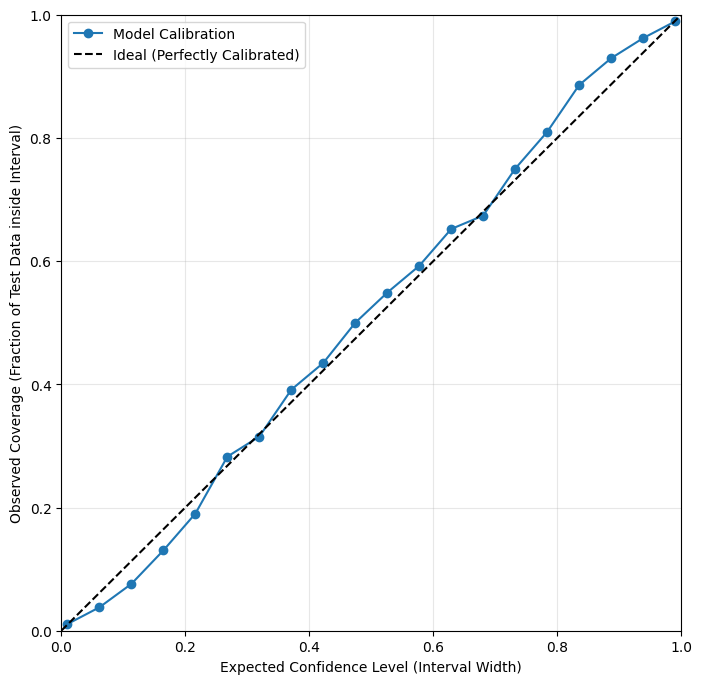

In [16]:
print("Harvey Hierarchical Model CRPS:", crps(harvey_hierarchical_idata))
print(
    "Harvey Hierarchical Model RMSE:",
    accuracy(harvey_hierarchical_idata, metric="RMSE"),
)
plot_calibration_curve(harvey_hierarchical_idata)

## Harvey independent model

In [ ]:
harvey_independent_idata = temporal_holdout(
    dataset, cutoff_date, sigmoid_kind="harvey", joint=False, top_n=3
)

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_29448/4077019860.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 441 seconds.
There were 2164 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Harvey Independent Model CRPS: 0.043969748138886544
Harvey Independent Model RMSE: 0.08198464800579568


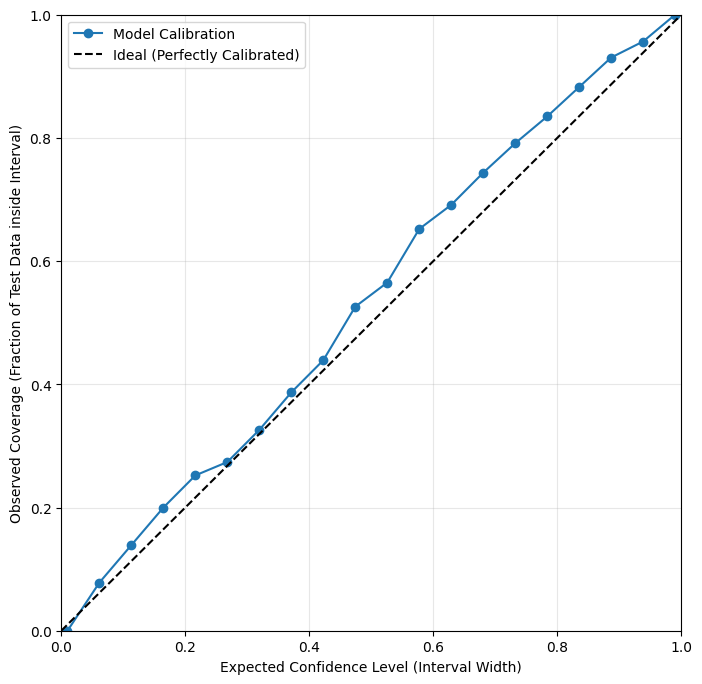

In [ ]:
print("Harvey Independent Model CRPS:", crps(harvey_independent_idata))
print(
    "Harvey Independent Model RMSE:", accuracy(harvey_independent_idata, metric="RMSE")
)
plot_calibration_curve(harvey_independent_idata)

## Logistic hierarchical (joint) model

In [ ]:
logistic_hierarchical_idata = temporal_holdout(
    dataset, cutoff_date, sigmoid_kind="logistic", joint=True, top_n=3
)

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_29448/4077019860.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Logistic Hierarchical Model CRPS: 0.043097848096999035
Logistic Hierarchical Model RMSE: 0.07668825324687963


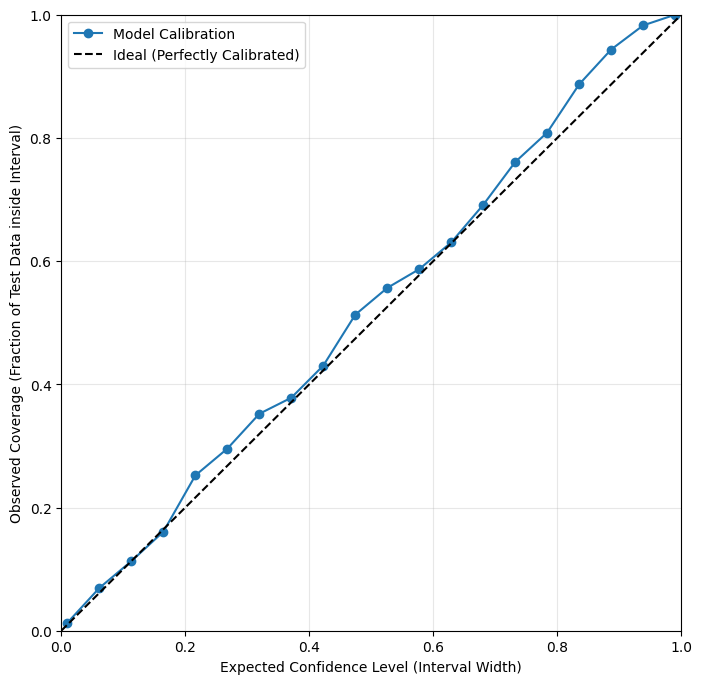

In [ ]:
print("Logistic Hierarchical Model CRPS:", crps(logistic_hierarchical_idata))
print(
    "Logistic Hierarchical Model RMSE:",
    accuracy(logistic_hierarchical_idata, metric="RMSE"),
)
plot_calibration_curve(logistic_hierarchical_idata)

## Logistic independent model

In [ ]:
logistic_independent_idata = temporal_holdout(
    dataset, cutoff_date, sigmoid_kind="logistic", joint=False, top_n=3
)

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_29448/4077019860.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_dataset = dataset[dataset["release_date"] >= cutoff_date][
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 383 seconds.
There were 2476 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Output()

Logistic Independent Model CRPS: 0.04574287618091316
Logistic Independent Model RMSE: 0.08526377579356174


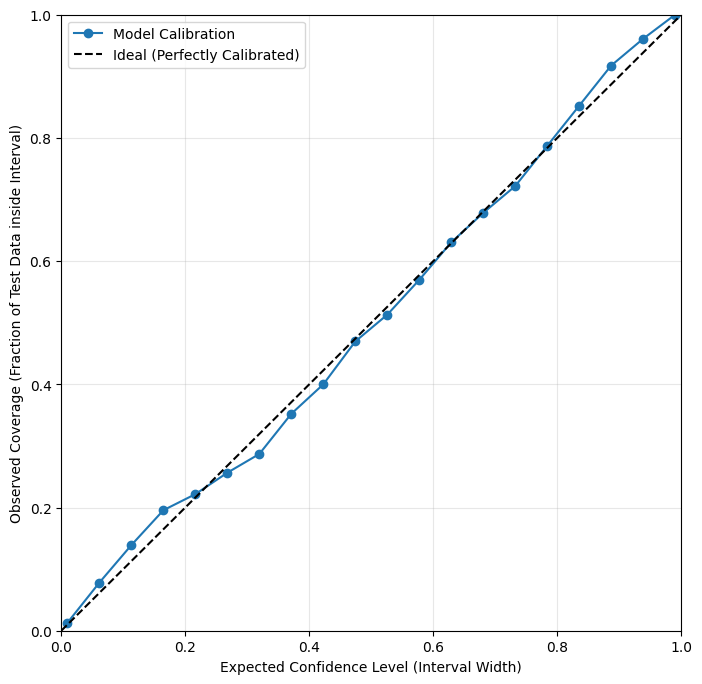

In [ ]:
print("Logistic Independent Model CRPS:", crps(logistic_independent_idata))
print(
    "Logistic Independent Model RMSE:",
    accuracy(logistic_independent_idata, metric="RMSE"),
)
plot_calibration_curve(logistic_independent_idata)

In [28]:
# Show all metrics together
print("Summary of Model Performance:")
models = {
    "Harvey Hierarchical": harvey_hierarchical_idata,
    "Harvey Independent": harvey_independent_idata,
    "Logistic Hierarchical": logistic_hierarchical_idata,
    "Logistic Independent": logistic_independent_idata,
}
for model_name, idata in models.items():
    model_crps = crps(idata)
    model_rmse = accuracy(idata, metric="RMSE")
    print(f"{model_name} - CRPS: {model_crps:.4f}, RMSE: {model_rmse:.4f}")

Summary of Model Performance:
Harvey Hierarchical - CRPS: 0.0443, RMSE: 0.0791
Harvey Independent - CRPS: 0.0440, RMSE: 0.0820
Logistic Hierarchical - CRPS: 0.0431, RMSE: 0.0767
Logistic Independent - CRPS: 0.0457, RMSE: 0.0853


# Tests

## Growth rate time evolution

In [26]:
df = format_dataset_for_modeling(dataset)

In [ ]:
idata, model = fit_model(df, sigmoid_kind="harvey", joint=True, top_n=3)


Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 118 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<Axes: xlabel='tau', ylabel='k'>

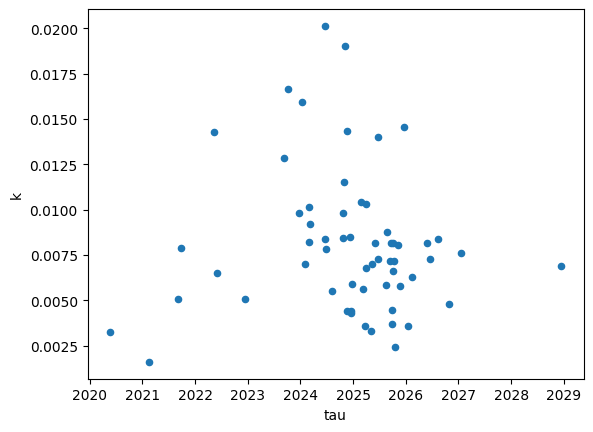

In [50]:
benchmark_first_dates = df.groupby("benchmark")["release_date"].min().reset_index()

inferred_parameters = (
    idata.posterior[["tau", "k"]]
    .mean(dim=("chain", "draw"))
    .to_dataframe()
    .reset_index()
    .assign(tau=lambda df: pd.to_timedelta(df["tau"], unit="D"))
    .merge(benchmark_first_dates, how="left", on="benchmark")
    .assign(tau=lambda df: df["release_date"] + df["tau"])
)

inferred_parameters.plot.scatter(x="tau", y="k")

## Test modelling

In [17]:
test_data = format_dataset_for_modeling(dataset, top_n=3)
idata, model = fit_model(test_data, sigmoid_kind="harvey", joint=False, top_n=3)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 693 seconds.
There were 1820 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y]


Output()

<Axes: xlabel='y'>

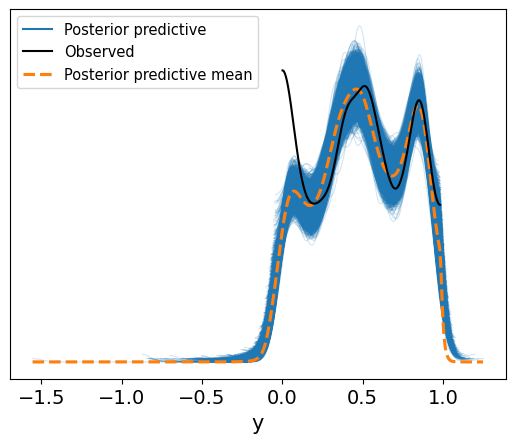

In [19]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
az.plot_ppc(idata)

array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'xi_base'}>,
        <Axes: title={'center': 'xi_base'}>],
       [<Axes: title={'center': 's'}>, <Axes: title={'center': 's'}>]],
      dtype=object)

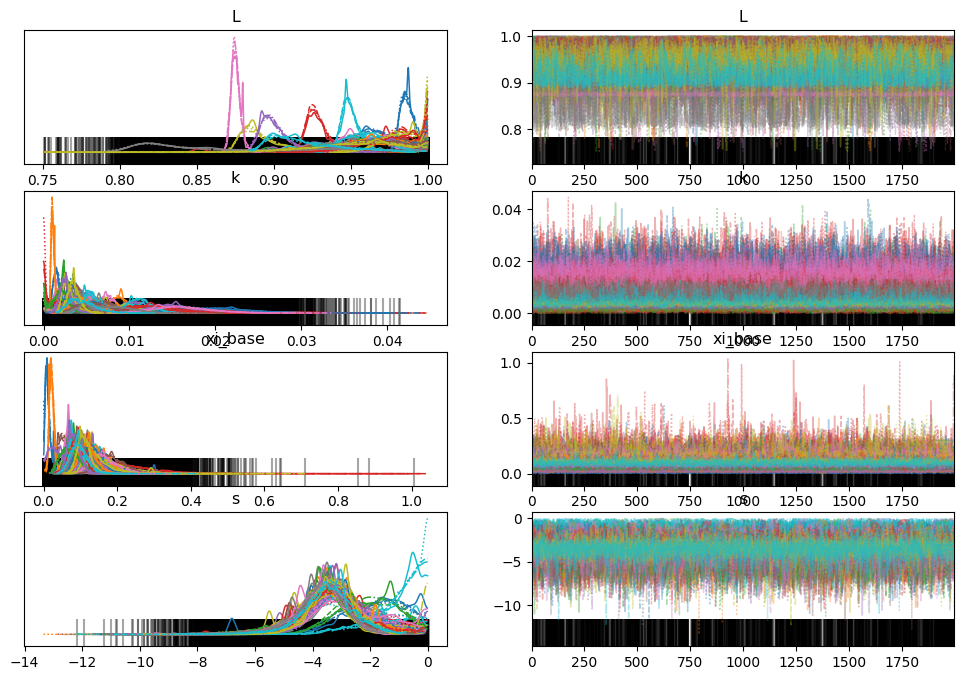

In [20]:
az.plot_trace(idata, var_names=["L", "k", "xi_base", "s"])

# Plotting

In [11]:
dataset = load_dataset()
dataset = format_dataset_for_modeling(dataset, top_n=3)
idata, model = fit_model(dataset, sigmoid_kind="harvey", joint=True, top_n=3)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L_raw_mu, L_raw_sigma, L_raw, tau, k_mu, k_sigma, k, alpha_raw_mu, alpha_raw_sigma, alpha_raw, xi_base_mu, xi_base_sigma, xi_base, s_mu, s_sigma, s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 125 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
def plot_benchmark_datapoints(
    datasubset: pd.DataFrame, 
    ax: plt.Axes, 
    color: str
) -> None:
    ax.scatter(
        datasubset["release_date"],
        datasubset["score"],
        s=40,
        color=color,
        marker='o',
        edgecolors='white',
        alpha=0.4,
        zorder=5
    )

def _create_date_grid(
    group: pd.DataFrame,
    end_date: pd.Timestamp,
    n_points: int,
) -> pd.DataFrame:
    """Create a time grid for a single benchmark group."""
    start_date = group["release_date"].min()
    date_range = pd.date_range(start=start_date, end=end_date, periods=n_points)
    
    return pd.DataFrame({
        "release_date": date_range, 
        # Fix: .days works directly on TimedeltaIndex, no .dt needed
        "days": (date_range - start_date).days,
        "benchmark": group["benchmark"].iloc[0],
        "category": group["category"].iloc[0],
    })

def generate_forecast(
    idata: az.InferenceData,
    model: pm.Model,
    frontier_datapoints: pd.DataFrame,
    end_date: pd.Timestamp,
    n_points: int = 100,
    ci_level: float = 0.8,
) -> pd.DataFrame:
    # Fix: Use 'frontier_datapoints' argument, not global 'dataset'
    predictions = (
        frontier_datapoints.groupby("benchmark", group_keys=False)
        .apply(
            lambda group: _create_date_grid(
                group,
                end_date=end_date,
                n_points=n_points,
            )
        )
        .reset_index(drop=True)
    )

    # explicit categorical coding to match model coordinates
    predictions["benchmark_idx"] = pd.Categorical(
        predictions["benchmark"],
        categories=model.coords["benchmark"],
        ordered=True,
    ).codes

    with model:
        pm.set_data(
            {
                "t_obs": predictions["days"].values,
                "idx_obs": predictions["benchmark_idx"].values,
            },
            coords={"obs": predictions.index},
        )
        posterior_predictive = pm.sample_posterior_predictive(
            idata,
            var_names=["mu"],
            predictions=True,
            random_seed=42,
            progressbar=False,
        )
    
    mu_pred = posterior_predictive.predictions.stack(sample=("chain", "draw"))["mu"].values
    predictions["mu_mean"] = np.mean(mu_pred, axis=1)
    predictions["mu_lower"] = np.quantile(mu_pred, (1 - ci_level) / 2, axis=1)
    predictions["mu_upper"] = np.quantile(mu_pred, 1 - (1 - ci_level) / 2, axis=1)

    # Process Tau mapping
    tau_offset_days = (
        idata.posterior["tau"]
        .mean(dim=("chain", "draw"))
        .to_series()
        .reset_index(name="tau_offset_days")
    )
    
    start_dates = (
        frontier_datapoints.groupby("benchmark", as_index=False)["release_date"]
        .min()
        .rename(columns={"release_date": "benchmark_first_date"})
    )
    
    benchmark_metadata = (
        pd.merge(start_dates, tau_offset_days, on="benchmark", how="inner")
        .assign(
            # Fix: Use the correct column name 'benchmark_first_date'
            tau_date=lambda df: df["benchmark_first_date"] + pd.to_timedelta(df["tau_offset_days"], unit="D")
        )
    )
    
    predictions = pd.merge(
        predictions, benchmark_metadata[["benchmark", "tau_date"]],
        on="benchmark", how="left"
    )
    return predictions

/var/folders/wc/cfb8c70d55l7nnd2jy67g3ww0000gp/T/ipykernel_61556/4180936300.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
Sampling: []


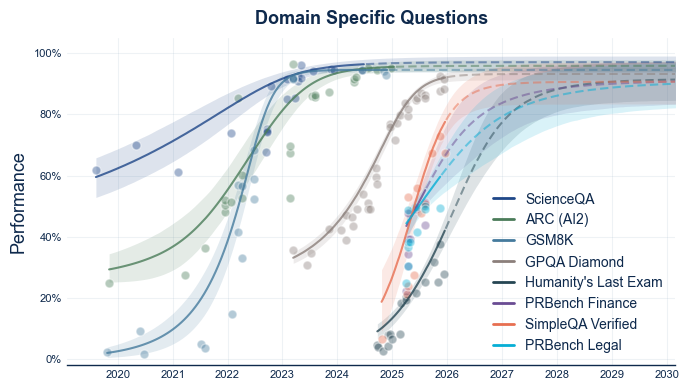

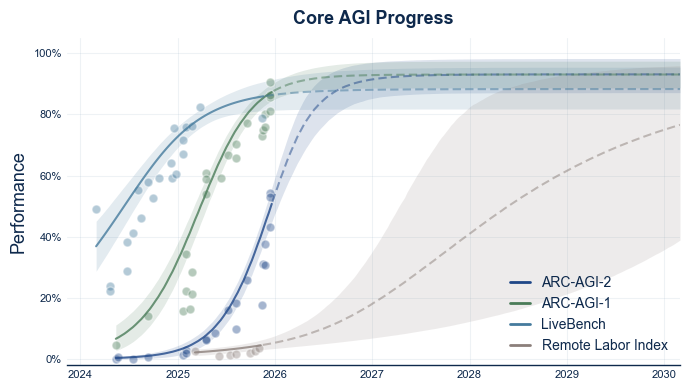

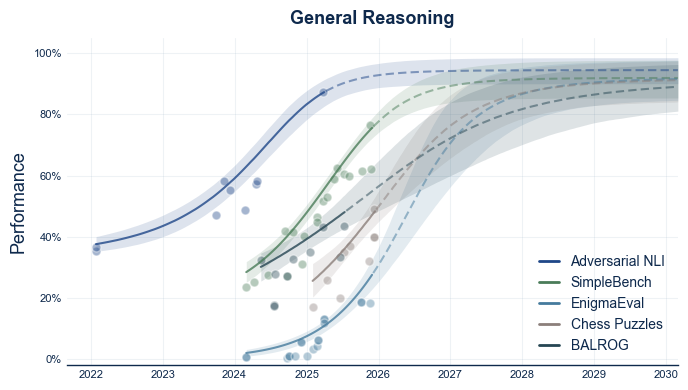

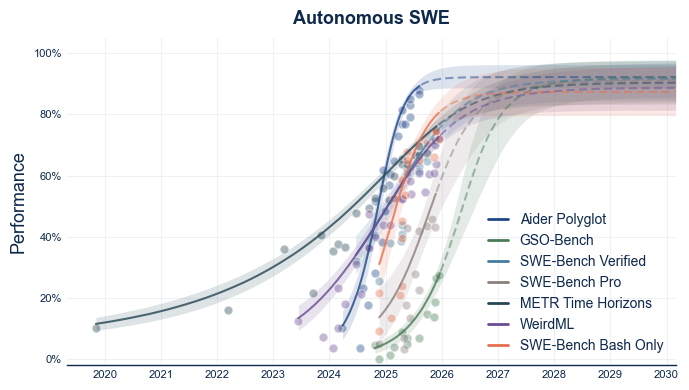

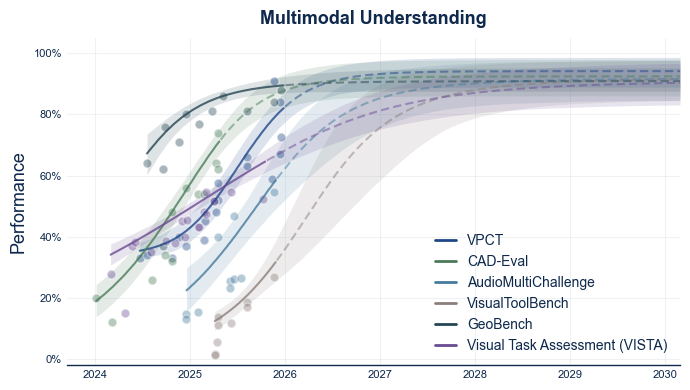

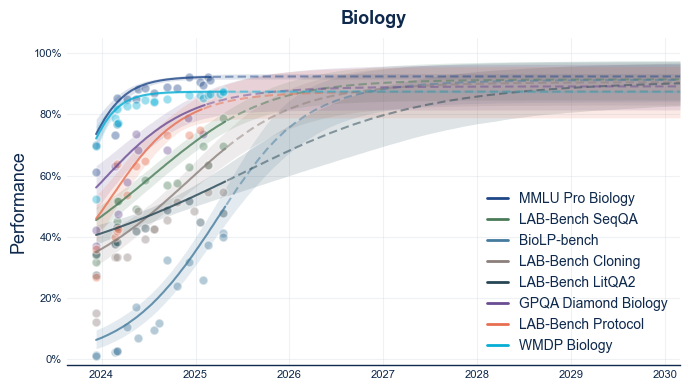

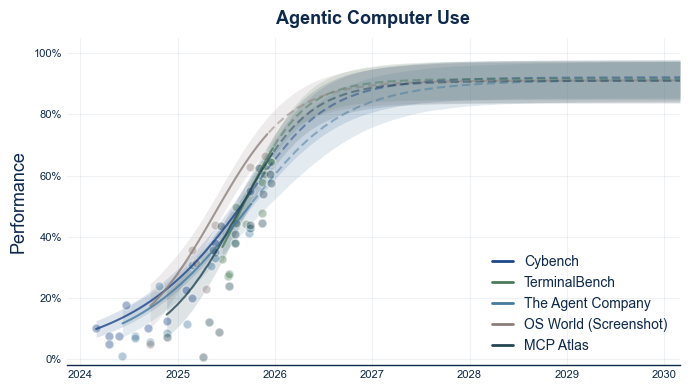

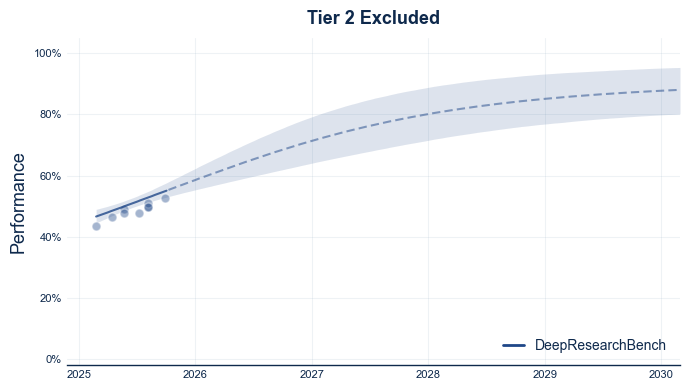

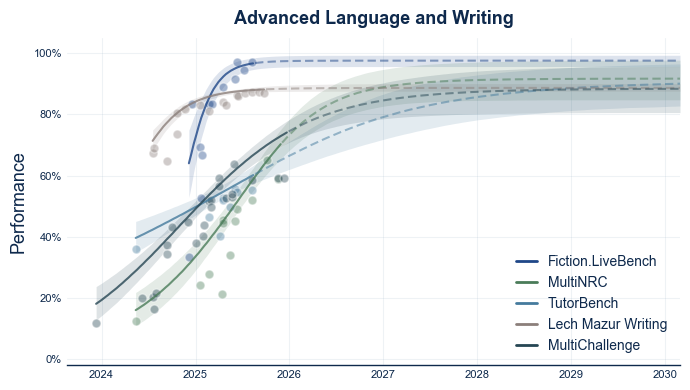

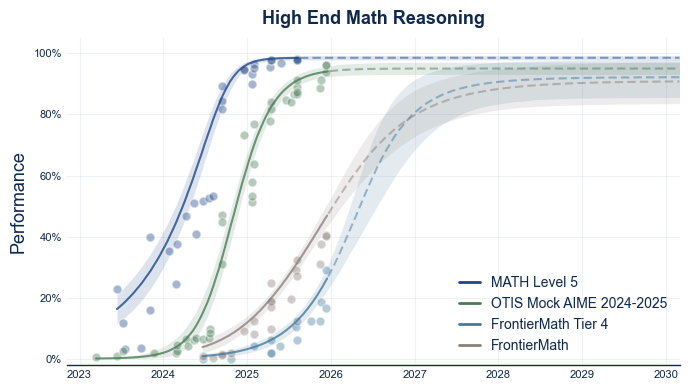

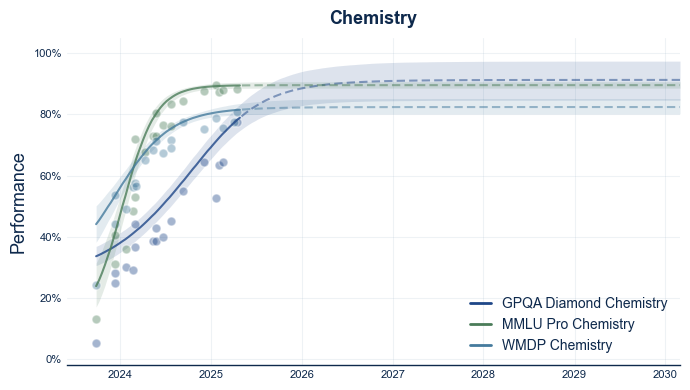

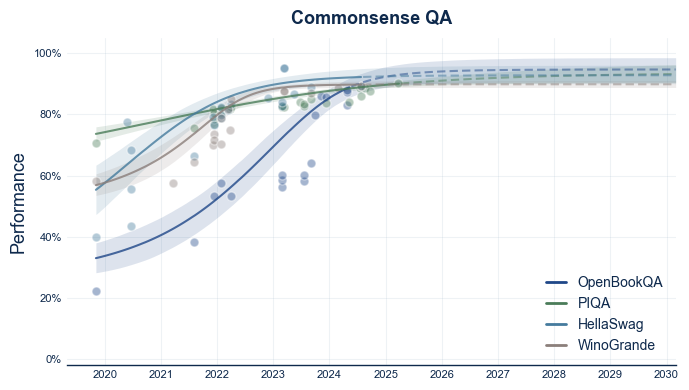

In [19]:
# TODO: sort benchmarks in order of perf, save them somewhere
# TODO: sample everything once then plot once
# TODO: put all magic numbers into variables at the top and then in a function

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['grid.alpha'] = 0.2

colors = {
    "base_color": "#0e294c",
    "accent_color": "#d4af37",
    "gray_color": "#6c757d",
    "grid_color": "#5F86A5",
    "plot_colors": [
        "#1f4788", "#4a7c59", "#457b9d", "#8b7f7b", "#264653",
        "#6a4c93", "#e76f51", "#06aed5", "#f4a261", "#2a9d8f",
    ],
}
end_date = pd.to_datetime("2030-03-01")
label_fontsize = 13

# 1. Sample everything once
all_forecasts = generate_forecast(
    idata, 
    model, 
    dataset, 
    end_date, 
    n_points=200, 
    ci_level=0.8
)

# 2. Plotting Loop
for category in dataset["category"].unique():
    subset_category = dataset[dataset["category"] == category]
    subset_forecast = all_forecasts[all_forecasts["category"] == category]
    
    # Sort benchmarks by their final predicted value so legend matches visual order
    final_perfs = (
        subset_forecast[subset_forecast["release_date"] == subset_forecast["release_date"].max()]
        .set_index("benchmark")["mu_mean"]
    )
    sorted_benchmarks = final_perfs.sort_values(ascending=False).index.tolist()
    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    for benchmark, color in zip(sorted_benchmarks, itertools.cycle(colors["plot_colors"])):
        # Data subsets
        bench_obs = subset_category[subset_category["benchmark"] == benchmark]
        bench_pred = subset_forecast[subset_forecast["benchmark"] == benchmark]
        
        # Plot observations
        plot_benchmark_datapoints(bench_obs, ax=ax, color=color)
        
        # Plot forecast
        # Split line style at the last observation date
        last_obs_date = bench_obs["release_date"].max()
        split_idx = bench_pred["release_date"].searchsorted(last_obs_date)
        
        # Solid line (history)
        ax.plot(
            bench_pred["release_date"][:split_idx+1],
            bench_pred["mu_mean"][:split_idx+1],
            linewidth=1.5,
            color=color,
            alpha=0.8,
            label=benchmark,
            zorder=6,
        )
        
        # Dashed line (future)
        ax.plot(
            bench_pred["release_date"][split_idx:],
            bench_pred["mu_mean"][split_idx:],
            linewidth=1.5,
            color=color,
            alpha=0.5,
            linestyle=(5, (4, 2)),
            zorder=6,
        )
        
        # Uncertainty band
        ax.fill_between(
            bench_pred["release_date"],
            bench_pred["mu_lower"],
            bench_pred["mu_upper"],
            color=color,
            alpha=0.15,
            linewidth=0,
            zorder=4
        )

    ax.set_xlim(right=end_date)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel(
        "", fontsize=label_fontsize, fontweight="500", color=colors["base_color"]
    )

    ax.set_ylim(-0.02, 1.05)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))
    ax.set_ylabel(
        "Performance",
        fontsize=label_fontsize,
        fontweight="500",
        color=colors["base_color"],
    )

    ax.grid(True, alpha=0.1, linewidth=0.8, color=colors["grid_color"])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_color(colors["base_color"])
    ax.tick_params(axis="y", left=False, right=False)
    ax.tick_params(labelsize=8, colors=colors["base_color"])

    legend = ax.legend(
        loc="lower right",
        fontsize=10,
        framealpha=0.95,
        edgecolor=colors["base_color"],
        fancybox=True,
        ncol=1,
        handlelength=1.5,
    )
    for text in legend.get_texts():
        text.set_color(colors["base_color"])
    for line in legend.get_lines():
        line.set_linewidth(2.0)
        line.set_linestyle("-")
        line.set_alpha(1.0)

    ax.set_title(
        category, fontsize=13, fontweight="600", color=colors["base_color"], pad=10
    )

    plt.tight_layout()
    plt.show()